<a href="https://colab.research.google.com/github/Johnnyr81/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [1]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [2]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=52.45618884865514, pvalue=4.067085670939157e-12)


In [3]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## T-test Assumptions

<https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php>

- Independence of means

Are the means of our voting data independent (do not affect the outcome of one another)?
  
The best way to increase thel likelihood of our means being independent is to randomly sample (which we did not do).


In [0]:
from scipy.stats import ttest_ind

?ttest_ind

- "Homogeneity" of Variance? 

Is the magnitude of the variance between the two roughly the same?

I think we're OK on this one for the voting data, although it probably could be better, one party was larger than the other.

If we suspect this to be a problem then we can use Welch's T-test

In [0]:
?ttest_ind

- "Dependent Variable" (sample means) are Distributed Normally

<https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50>

Lots of statistical tests depend on normal distributions. We can test for normality using Scipy as was shown above.

This assumption is often assumed even if the assumption is a weak one. If you strongly suspect that things are not normally distributed, you can transform your data to get it looking more normal and then run your test. This problem typically goes away for large sample sizes (yay Central Limit Theorem) and is often why you don't hear it brought up. People declare the assumption to be satisfied either way. 



## Central Limit Theorem



In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sample_means = []
for x in range(0,3000):
  coinflips = np.random.binomial(n=1, p=.5, size=12)
  one_sample = coinflips
  sample_means.append(coinflips.mean())

print(len(sample_means))
print(sample_means)

3000
[0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.3333333333333333, 0.5833333333333334, 0.5833333333333334, 0.4166666666666667, 0.25, 0.5, 0.5, 0.5833333333333334, 0.5833333333333334, 0.3333333333333333, 0.5, 0.5, 0.5833333333333334, 0.6666666666666666, 0.5, 0.5, 0.5833333333333334, 0.5833333333333334, 0.6666666666666666, 0.5833333333333334, 0.5, 0.4166666666666667, 0.5833333333333334, 0.6666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.75, 0.6666666666666666, 0.4166666666666667, 0.5833333333333334, 0.4166666666666667, 0.3333333333333333, 0.8333333333333334, 0.4166666666666667, 0.3333333333333333, 0.4166666666666667, 0.5, 0.5, 0.5, 0.6666666666666666, 0.6666666666666666, 0.5, 0.4166666666666667, 0.4166666666666667, 0.5, 0.4166666666666667, 0.5, 0.5, 0.4166666666666667, 0.6666666666666666, 0.5833333333333334, 0.5, 0.3333333333333333, 0.4166666666666667, 0.5, 0.3333333333333333, 0.5, 0.4166666666666667, 0.5, 0.5, 0.5833333333333334, 0.4166666666666667, 0.

In [7]:
df = pd.DataFrame({'a': one_sample})
df.head()

,a
0,0
1,1
2,0
3,1
4,1


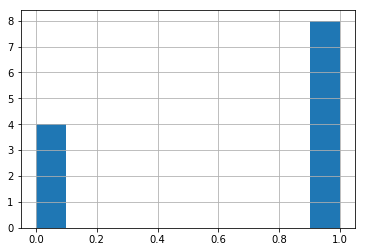

In [8]:
df.a.hist()

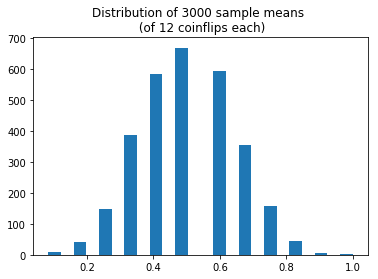

In [9]:
ax = plt.hist(sample_means, bins=24)
plt.title('Distribution of 3000 sample means \n (of 12 coinflips each)');

What does the Central Limit Theorem State? That no matter the initial distribution of the population, the distribution of sample means taken will approximate a normal distribution as $n \rightarrow \infty$.

This has very important implications for hypothesis testing and is precisely the reason why the t-distribution begins to approximate the normal distribution as our sample size increases. 

## Standard Error of the Mean

What does it mean to "estimate"? the Population mean?

## Build and Interpret a Confidence Interval

<img src="https://github.com/ryanallredblog/ryanallredblog.github.io/blob/master/img/Confidence_Interval.png?raw=true" width=400>

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

## Graphically Represent a Confidence Interval

## Relationship between Confidence Intervals and T-tests

Confidence Interval == Bounds of statistical significance for our t-test

A sample mean that falls inside of our confidence interval will "FAIL TO REJECT" our null hypothesis

A sample mean that falls outside of our confidence interval will "REJECT" our null hypothesis

In [0]:
from scipy.stats import t, ttest_1samp

In [12]:
import numpy as np

coinflip_means = []
for x in range(0,100):
  coinflips = np.random.binomial(n=1, p=.5, size=30)
  coinflip_means.append(coinflips.mean())

print(coinflip_means)

[0.5333333333333333, 0.6, 0.4666666666666667, 0.5, 0.6333333333333333, 0.43333333333333335, 0.4, 0.5333333333333333, 0.4666666666666667, 0.36666666666666664, 0.4, 0.4, 0.4, 0.5, 0.36666666666666664, 0.4, 0.43333333333333335, 0.4666666666666667, 0.36666666666666664, 0.36666666666666664, 0.6666666666666666, 0.5333333333333333, 0.5, 0.4666666666666667, 0.4, 0.6, 0.5666666666666667, 0.6, 0.5666666666666667, 0.6, 0.43333333333333335, 0.43333333333333335, 0.4666666666666667, 0.5333333333333333, 0.6, 0.5, 0.43333333333333335, 0.6333333333333333, 0.5333333333333333, 0.5666666666666667, 0.5333333333333333, 0.6333333333333333, 0.4666666666666667, 0.6666666666666666, 0.4666666666666667, 0.5666666666666667, 0.3, 0.5, 0.4666666666666667, 0.5666666666666667, 0.5, 0.3333333333333333, 0.4666666666666667, 0.5, 0.5666666666666667, 0.4, 0.7666666666666667, 0.7, 0.43333333333333335, 0.43333333333333335, 0.4666666666666667, 0.4666666666666667, 0.5, 0.43333333333333335, 0.4666666666666667, 0.6, 0.6333333333

In [13]:
# Sample Size
n = len(coinflip_means)
# Degrees of Freedom
dof = n-1
# The Mean of Means:
mean = np.mean(coinflip_means)
# Sample Standard Deviation
sample_std = np.std(coinflip_means, ddof=1)
# Standard Error
std_err = sample_std/n**.5

CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.47498368315358147, 0.511682983513085)


In [14]:
'''You can roll your own CI calculation pretty easily. 
The only thing that's a little bit challenging 
is understanding the t stat lookup'''

# 95% confidence interval
t_stat = t.ppf(.975, dof)
print("t Statistic:", t_stat)

CI = (mean-(t_stat*std_err), mean+(t_stat*std_err))
print("Confidence Interval", CI)

t Statistic: 1.9842169515086827
Confidence Interval (0.47498368315358147, 0.511682983513085)


A null hypothesis that's just inside of our confidence interval == fail to reject



In [15]:
ttest_1samp(coinflip_means, .49)

Ttest_1sampResult(statistic=0.3604459180550073, pvalue=0.7192815957838008)

A null hypothesis that's just outside of our confidence interval == reject



In [16]:
ttest_1samp(coinflip_means, .4818927)

Ttest_1sampResult(statistic=1.2371188754892226, pvalue=0.21896939960382117)

## Run a $\chi^{2}$ Test "by hand" (Using Numpy)

## Run a $\chi^{2}$ Test using Scipy

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data')

import numpy as np

In [18]:
df.head()

,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,y.4,?,y.5,y.6,y.7,n.5,y.8
0,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
1,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
2,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
3,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
4,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y


In [19]:
df = df.replace(to_replace=['n', 'y', '?'], value=[0, 1, np.nan])
df.head()

,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,y.4,?,y.5,y.6,y.7,n.5,y.8
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
1,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
4,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [20]:
df.columns = ['party',
'handicapped',
'water',
'adoption',
'physician',
'salvador' ,
'religious',
'satellite',
'nicaraguan',
'missile',
'immigration',
'synfuels',
'education',
'superfund' ,
'crime',
'duty' ,
'export']

df.head()

,party,handicapped,water,adoption,physician,salvador,religious,satellite,nicaraguan,missile,immigration,synfuels,education,superfund,crime,duty,export
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
1,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
4,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [21]:
rep = df[df['party'] == 'republican']
rep.head()

,party,handicapped,water,adoption,physician,salvador,religious,satellite,nicaraguan,missile,immigration,synfuels,education,superfund,crime,duty,export
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
6,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
9,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0
10,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,NaN,NaN


In [22]:
dem = df[df['party'] == 'democrat']
dem.head()

,party,handicapped,water,adoption,physician,salvador,religious,satellite,nicaraguan,missile,immigration,synfuels,education,superfund,crime,duty,export
1,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
4,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [23]:
print("Democrat Support: ", dem['crime'].mean())
print("Republican Support: ", rep['crime'].mean())

Democrat Support:  0.35019455252918286
Republican Support:  0.98125


In [24]:
print("Democrat Support: ", dem['crime'].std())
print("Republican Support: ", rep['crime'].std())

Democrat Support:  0.4779615336263577
Republican Support:  0.13606671504595172


In [25]:
dem_crime= pd.DataFrame({'democrat_crime': dem['crime']})
print(dem_crime.shape)
dem_crime.head()


(267, 1)


,democrat_crime
1,1.0
2,0.0
3,1.0
4,1.0
5,1.0


In [26]:
import numpy as np

sample_dv= np.std(dem_crime)
print('sample standard deviation:', sample_dv)
sample_size= len(dem_crime)
print('sample size:', sample_size)

sample standard deviation: democrat_crime    0.477031
dtype: float64
sample size: 267


In [27]:
standard_error = sample_dv / (sample_size**(.5))

print("standard error:", standard_error)

standard error: democrat_crime    0.029194
dtype: float64


In [0]:
from scipy import stats
t = stats.t.ppf(.975 , sample_size-1)

In [0]:
sample_mean = dem_crime.mean()

In [30]:
confidence_interval = (sample_mean - t*standard_error, sample_mean + t*standard_error)

margin_of_error = t*standard_error

print("Sample Mean", sample_mean)
print("Margin of Error:", margin_of_error)
print("Confidence Interval:", confidence_interval)

Sample Mean democrat_crime    0.350195
dtype: float64
Margin of Error: democrat_crime    0.05748
dtype: float64
Confidence Interval: (democrat_crime    0.292714
dtype: float64, democrat_crime    0.407675
dtype: float64)


In [31]:
confidence_interval[0]

democrat_crime    0.292714
dtype: float64

In [32]:
confidence_interval[0]

democrat_crime    0.292714
dtype: float64

In [33]:
confidence_interval[1]

democrat_crime    0.407675
dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


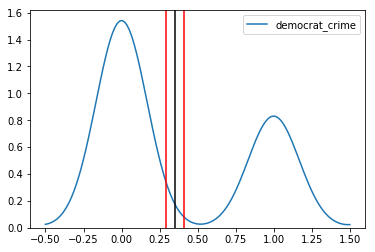

In [34]:
import seaborn as sns

sns.kdeplot(dem_crime['democrat_crime'])
plt.axvline(x=float(confidence_interval[0]), color='red')
plt.axvline(x=float(confidence_interval[1]), color='red')
plt.axvline(x=float(sample_mean), color='k');


In [0]:
# Confidence interval 2

In [0]:
import numpy as np
from scipy import stats


def conf_interval(data, confidence=0.5):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1+confidence)/2.0, n-1)
  return(mean, mean - interval, mean + interval)

In [37]:
def con_int_df(df):
  con_int = []
  df= df.values.T
  cleaned_df = []
  for col in df:
      cleaned_col = col[~np.isnan(col)]
      con_int.append(conf_interval(cleaned_col))
  df_out = pd.DataFrame(con_int, columns=['mean', 'lower', 'upper'])    
  return df_out
only_votes = dem.drop('party', axis='columns')
con_int_df = con_int_df(only_votes)
con_int_df.head()
    

,mean,lower,upper
0,0.604651,0.584051,0.625251
1,0.502092,0.480198,0.523986
2,0.888462,0.875250,0.901674
3,0.054054,0.044545,0.063563
4,0.215686,0.198255,0.233118


**Bayesian Example**

In [38]:
dem_crime= pd.DataFrame({'democrat_crime': dem['crime']})
print(dem_crime.shape)
dem_crime.head()


(267, 1)


,democrat_crime
1,1.0
2,0.0
3,1.0
4,1.0
5,1.0


In [51]:
dem_religious= pd.DataFrame({'democrat_religious': dem['religious']})
print(dem_religious.shape)
dem_religious.head()

(267, 1)


,democrat_religious
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0


In [59]:
rep_crime= pd.DataFrame({'republican_crime': rep['crime']})

rep_crime.head()

,republican_crime
0,1.0
6,1.0
7,1.0
9,1.0
10,1.0


In [40]:
dem_comb= pd.concat((dem_crime['democrat_crime'],dem_religious['democrat_religious']),axis=1)
dem_comb.head()

,democrat_crime,democrat_religious
1,1.0,1.0
2,0.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0


In [0]:
cleaned_dem = dem_crime['democrat_crime'].dropna()
cleaned_dem2 = dem_religious['democrat_religious'].dropna()

In [67]:

bayes_mean_CI, _, _ = stats.bayes_mvs(cleaned_dem, alpha=.95)
bayes_mean_CI

Mean(statistic=0.35019455252918286, minmax=(0.2914817910969736, 0.4089073139613921))

In [79]:
bayes_mean_CI, _, _ = stats.bayes_mvs(cleaned_dem2, alpha=.95)
bayes_mean_CI

Mean(statistic=0.47674418604651164, minmax=(0.41539182663748236, 0.5380965454555409))

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


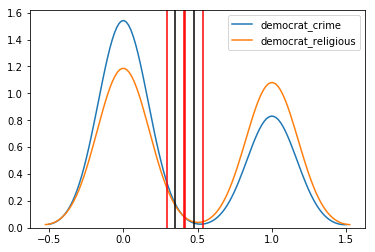

In [80]:
sns.kdeplot(dem_crime['democrat_crime'])
sns.kdeplot(dem_religious['democrat_religious'])
plt.axvline(x=float(0.2914817910969736), color='red')
plt.axvline(x=float(0.408907313961392), color='red')
plt.axvline(x=float(0.35019455252918286), color='k')

plt.axvline(x=float(0.41539182663748236), color='red')
plt.axvline(x=float(0.5380965454555409), color='red')
plt.axvline(x=float(0.47674418604651164), color='k');


**Chi2 test**


In [44]:
chi2 =  pd.crosstab(df['party'], df['adoption'])
chi2

adoption,0.0,1.0
party,,
democrat,29,231
republican,141,22


In [45]:
# Chi test in a single line using Scipy

chi_squared, p_value, dof, expected = stats.chi2_contingency(chi2)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 233.51640889058146
P-value: 1.0197580728708687e-52
Degrees of Freedom: 1
Expected: 
 [[104.49172577 155.50827423]
 [ 65.50827423  97.49172577]]


## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)